Win rate for 4x4 board: 0.65
Win rate for 5x5 board: 0.41


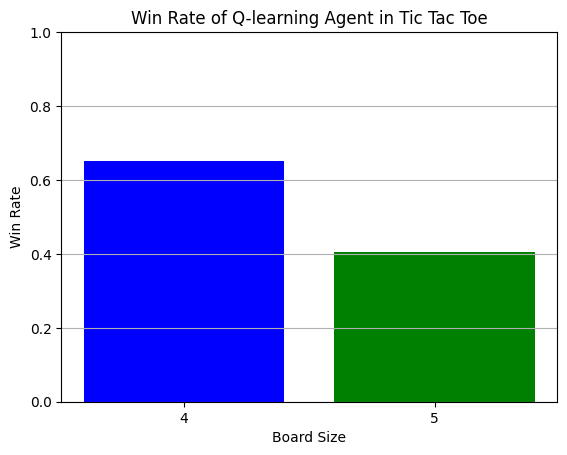

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class TicTacToe:
    def __init__(self, size=3):
        self.size = size
        self.board = np.zeros((size, size))
        self.current_player = 1  # Player 1 is represented by 1, Player 2 by -1

    def reset(self):
        self.board = np.zeros((self.size, self.size))
        self.current_player = 1

    def is_winner(self, player):
        # Check rows.
        for i in range(self.size):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
        # Check diag.
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        return False

    def is_full(self):
        return np.all(self.board != 0)

    def step(self, action):
        x, y = action
        self.board[x, y] = self.current_player
        reward = 0

        if self.is_winner(self.current_player):
            reward = 1  # Current player wins
        elif self.is_full():
            reward = 0.5  # Draw

        self.current_player *= -1  # Switch player
        return reward

class QLearningAgent:
    def __init__(self, size):
        self.size = size
        self.q_table = {}
        self.epsilon = 0.1  # Exploration rate
        self.alpha = 0.5    # Learning rate
        self.gamma = 0.9    # Discount factor

    # Generate string for storage.
    def get_state_key(self, state):
        return str(state.flatten())

    # Decide next move.
    def choose_action(self, state):
        # Get available actions as list of coordinates.
        available_actions = np.argwhere(state == 0)  
        # Randomly decide if agent explore or revisit.
        if np.random.rand() < self.epsilon:
            # Choose a random action from available ones.
            action_index = np.random.choice(len(available_actions))
            action = tuple(available_actions[action_index])
        else:
            # Revisit.
            state_key = self.get_state_key(state)
            if state_key not in self.q_table:
                self.q_table[state_key] = np.zeros((self.size, self.size))
                
            # Choose the action with the highest Q-value
            q_values = self.q_table[state_key]
            max_q_value_action = np.argmax(q_values.flatten())
            
            # Pick whatever the largest-value action is and then check for availability.
            action = np.unravel_index(max_q_value_action, (self.size, self.size))
            if state[action] != 0: 
                action_index = np.random.choice(len(available_actions))
                action = tuple(available_actions[action_index])

        return action


    def learn(self, state, action, reward, next_state):
        # Convert board states to keys
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        # If not visited yet.
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros((self.size, self.size))
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros((self.size, self.size))

        # Get current Q-value for the action
        current_q_value = self.q_table[state_key][action]
        
        # Get maximum Q-value for the next state
        max_future_q_value = np.max(self.q_table[next_state_key])
        
        # Update the Q-value using the Q-learning formula
        new_q_value = current_q_value + self.alpha * (reward + self.gamma * max_future_q_value - current_q_value)
        self.q_table[state_key][action] = new_q_value


def train_agent(size, episodes):
    agent = QLearningAgent(size)
    wins = 0
    draws = 0

    for episode in range(episodes):
        game = TicTacToe(size)
        game.reset()
        while True:
            state = game.board.copy()
            action = agent.choose_action(state)
            reward = game.step(action)

            next_state = game.board.copy()
            agent.learn(state, action, reward, next_state)

            if reward == 1:  # Current player wins
                wins += 1
                break
            elif reward == 0.5:  # Draw
                draws += 1
                break

    return wins, draws

def main():
    sizes = [4, 5]
    episodes = 10000
    results = {}

    for size in sizes:
        wins, draws = train_agent(size, episodes)
        total_games = wins + draws
        win_rate = wins / total_games if total_games > 0 else 0
        results[size] = win_rate
        print(f"Win rate for {size}x{size} board: {win_rate:.2f}")

    # Plotting the results
    plt.bar(results.keys(), results.values(), color=['blue', 'green'])
    plt.xlabel('Board Size')
    plt.ylabel('Win Rate')
    plt.title('Win Rate of Q-learning Agent in Tic Tac Toe')
    plt.xticks([4, 5])
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.show()

if __name__ == "__main__":
    main()
